In [35]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.manifold import TSNE
from PIL import Image
import os
import csv
import random

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

import data_loader

import warnings
warnings.filterwarnings('ignore')

In [63]:
# Method to extract features from a given image
def extract_features(image, verbose=None):
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv2').output)
    img_features = model.predict(np.expand_dims(image, axis=0), verbose=verbose)
    return img_features.flatten()

In [48]:
# Method to calculate the average distance between two clusters
def calculate_cluster_distance(cluster_1, cluster_2):
    distances_cluster1 = np.sqrt(np.sum((cluster_1[:, np.newaxis] - cluster_1) ** 2, axis=-1))
    distances_cluster2 = np.sqrt(np.sum((cluster_2[:, np.newaxis] - cluster_2) ** 2, axis=-1))
    
    # Calculate the average distance between clusters
    avg_distance = (np.sum(distances_cluster1) + np.sum(distances_cluster2)) / (len(cluster_1) * len(cluster_2))
    return avg_distance


In [37]:
# Import Data
input_path = 'tf/input'
train_data, test_data, val_data = data_loader.get_data_unbatched(input_path)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [38]:
# Create a list where each entry corresponds to one class containing a list of all the filepaths
with open('tf/input/birds.csv', 'r') as csv_file:
    reader = csv.DictReader(csv_file)
    paths_by_label = {}
    for row in reader:
        image_path = row['filepaths']
        label = row['labels']
        # Check if label exists already
        if label in paths_by_label:
            paths_by_label[label].append(image_path)
        else:
            paths_by_label[label] = [image_path]

# Convert the dictionary to a list
list_of_paths_by_label = list(paths_by_label.values())

# Verify correctness of the sorting process
print(list_of_paths_by_label[0])

# Print the result
"""
for idx, paths in enumerate(list_of_paths_by_label):
    print(f"Class {idx + 1}: {paths}")
"""

['train/ABBOTTS BABBLER/001.jpg', 'train/ABBOTTS BABBLER/007.jpg', 'train/ABBOTTS BABBLER/008.jpg', 'train/ABBOTTS BABBLER/009.jpg', 'train/ABBOTTS BABBLER/002.jpg', 'train/ABBOTTS BABBLER/003.jpg', 'train/ABBOTTS BABBLER/004.jpg', 'train/ABBOTTS BABBLER/005.jpg', 'train/ABBOTTS BABBLER/006.jpg', 'train/ABBOTTS BABBLER/010.jpg', 'train/ABBOTTS BABBLER/016.jpg', 'train/ABBOTTS BABBLER/017.jpg', 'train/ABBOTTS BABBLER/039.jpg', 'train/ABBOTTS BABBLER/040.jpg', 'train/ABBOTTS BABBLER/023.jpg', 'train/ABBOTTS BABBLER/025.jpg', 'train/ABBOTTS BABBLER/027.jpg', 'train/ABBOTTS BABBLER/015.jpg', 'train/ABBOTTS BABBLER/077.jpg', 'train/ABBOTTS BABBLER/014.jpg', 'train/ABBOTTS BABBLER/073.jpg', 'train/ABBOTTS BABBLER/024.jpg', 'train/ABBOTTS BABBLER/032.jpg', 'train/ABBOTTS BABBLER/026.jpg', 'train/ABBOTTS BABBLER/034.jpg', 'train/ABBOTTS BABBLER/028.jpg', 'train/ABBOTTS BABBLER/036.jpg', 'train/ABBOTTS BABBLER/022.jpg', 'train/ABBOTTS BABBLER/038.jpg', 'train/ABBOTTS BABBLER/021.jpg', 'train/AB

'\nfor idx, paths in enumerate(list_of_paths_by_label):\n    print(f"Class {idx + 1}: {paths}")\n'

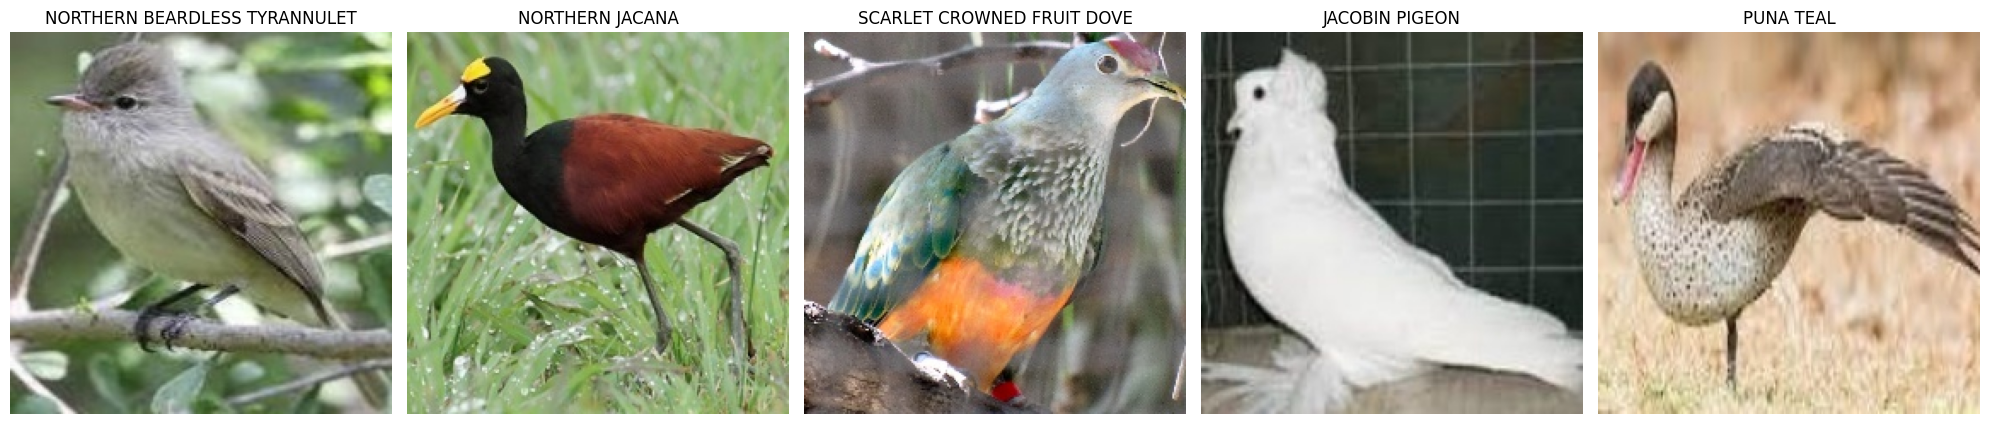

In [39]:
# Show n random images of a random class
paths = random.sample(sum(list_of_paths_by_label, []), 5)

# Display 5 images side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 20))

for i, img_path in enumerate(paths):
    full_path = os.path.join('tf/input', img_path)
    img = Image.open(full_path)
    img_label = img_path.split('/')[1]
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(img_label)

plt.tight_layout()
plt.show()

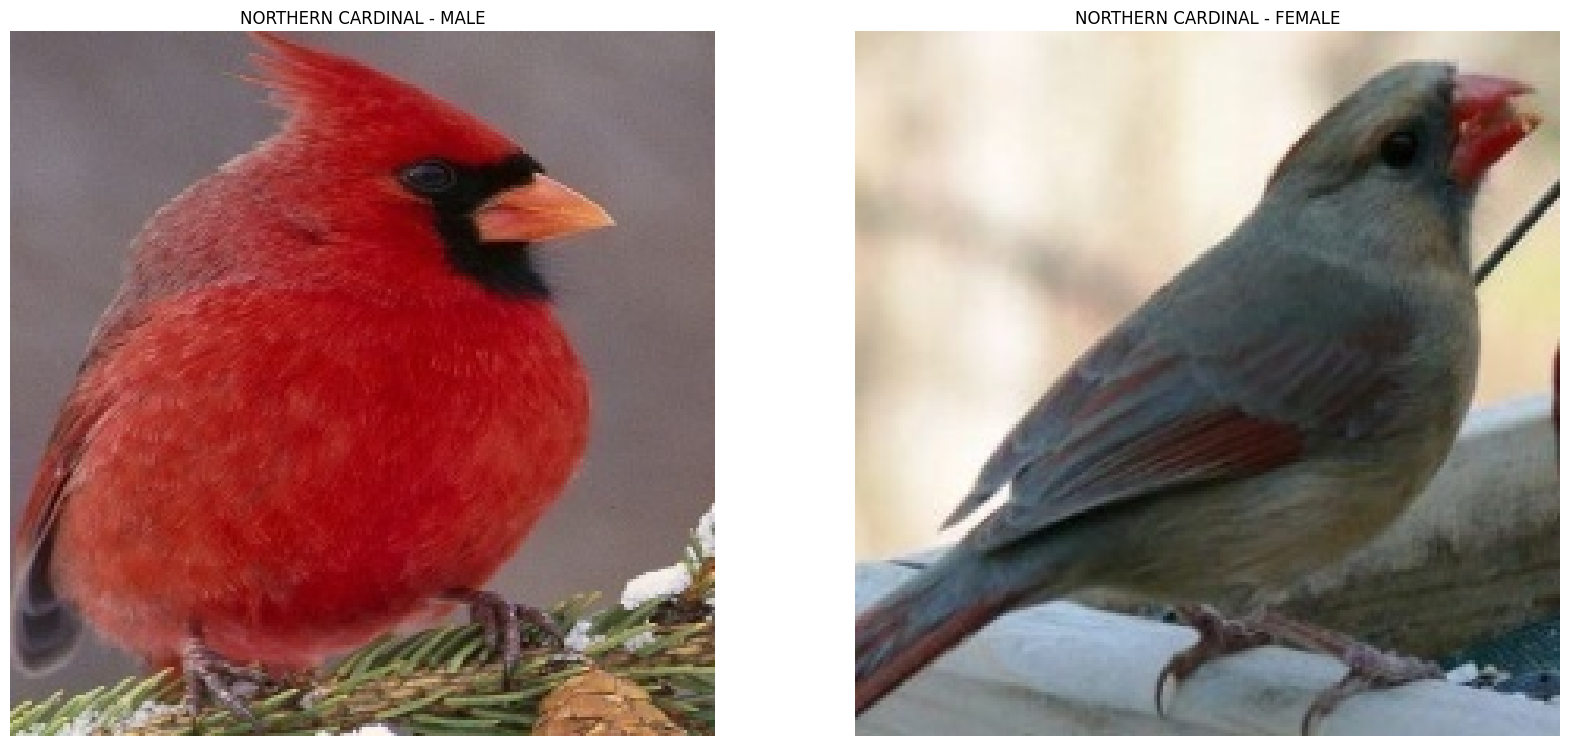

In [40]:
# Inspection of the northern cardinal

# By manual research, we take the Northern Cardinal as an example of a non-monomorphic species.
# The difference of males and females are clearly visible:

fig, axes = plt.subplots(1, 2, figsize=(20, 20))
nc_paths = ['train/NORTHERN CARDINAL/019.jpg', 'train/NORTHERN CARDINAL/010.jpg']
for i, img_path in enumerate(nc_paths):
    full_path = os.path.join('tf/input', img_path)
    img = Image.open(full_path)
    img_label = img_path.split('/')[1]
    if i == 0:
        img_label = f'{img_label} - MALE'
    else:
        img_label = f'{img_label} - FEMALE'
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(img_label)

In [46]:
# Extract features for the Northern Cardinal:

nc_img_paths = paths_by_label['NORTHERN CARDINAL']
all_features = []

for img_path in nc_img_paths:
    full_path = os.path.join('tf/input', img_path)
    img = Image.open(full_path)
    img_matrix = np.array(img)
    features = extract_features(img_matrix)
    all_features.append(features)

all_features = np.array(all_features)

# Standardise
scaler = StandardScaler()
scaled_features = scaler.fit_transform(all_features)

1/1 [==============================] - 0s 166ms/step


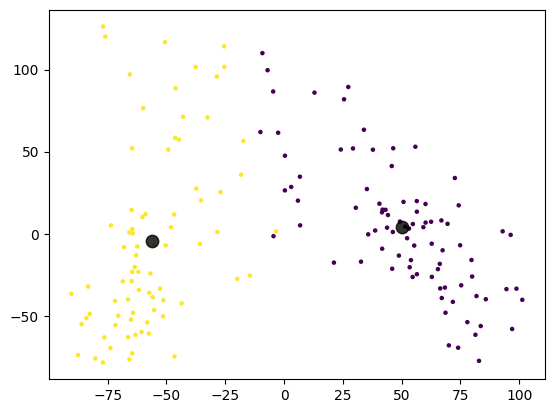

In [58]:
# Run PCA on features for the Northern Cardinal

num_components = 10
pca = PCA(n_components=num_components)
reduced_features = pca.fit_transform(scaled_features)

# Step 6: Apply KMeans clustering to each class

clusters = KMeans(n_clusters=2, n_init="auto").fit(reduced_features)
y_kmeans = clusters.predict(reduced_features)
# Retrieve scores (SSE)
score = clusters.score(reduced_features)
# Retrieve cluster centers
cntr = clusters.cluster_centers_
# Create subplots
X = reduced_features
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5)
plt.scatter(cntr[:, 0], cntr[:, 1], c='black', s=80, alpha=0.8)
plt.show()

In [59]:
# Calculate distance between clusters
cluster = []
for cluster_idx in range(2):
    cluster_points = reduced_features[y_kmeans == cluster_idx]
    cluster.append(cluster_points)

dist = calculate_cluster_distance(cluster[0], cluster[1])
print(dist)

313.9849322133805


Now we calculated the average cluster distance for one species.
The idea is to repeat this process for every species and compare the distance. We want to find a threshold so that we can tell if a distance between clusters is large enough to say that this specific species is non-monomorphic.

In [64]:
cluster_distances = []
progress_counter = 0

for species_path in list_of_paths_by_label:
    
    # Keep track of overall progress (executing this block takes some time) 
    progress_counter += 1
    print(f'Processing class {progress_counter} out of {len(list_of_paths_by_label)}')

    all_features = []
    
    for img_path in species_path:
        full_path = os.path.join('tf/input', img_path)
        img = Image.open(full_path)
        img_matrix = np.array(img)
        features = extract_features(img_matrix)
        all_features.append(features)
    
    all_features = np.array(all_features)
    
    # Standardise
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(all_features)
    
    num_components = 10
    pca = PCA(n_components=num_components)
    reduced_features = pca.fit_transform(scaled_features)
    
    # Step 6: Apply KMeans clustering to each class
    clusters = KMeans(n_clusters=2, n_init="auto").fit(reduced_features)
    y_kmeans = clusters.predict(reduced_features)
    
    cluster = []
    for cluster_idx in range(2):
        cluster_points = reduced_features[y_kmeans == cluster_idx]
        cluster.append(cluster_points)
    
    dist = calculate_cluster_distance(cluster[0], cluster[1])
    cluster_distances.append(dist)
    print(f'Cluster distance: {dist}')
    

Processing class 1 out of 525
Cluster distance: 296.25404858299595
Processing class 2 out of 525
Cluster distance: 351.1888746334311
Processing class 3 out of 525
Cluster distance: 486.57597557551935
Processing class 4 out of 525
Cluster distance: 325.616166921314
Processing class 5 out of 525
Cluster distance: 299.0328947368421
Processing class 6 out of 525
Cluster distance: 332.008149065955
Processing class 7 out of 525
Cluster distance: 329.2528571428571
Processing class 8 out of 525
Cluster distance: 323.2298701298701
Processing class 9 out of 525
Cluster distance: 296.23221946263266
Processing class 10 out of 525
Cluster distance: 353.6236148049645
Processing class 11 out of 525
Cluster distance: 338.1074913892078
Processing class 12 out of 525
Cluster distance: 316.610014717688
Processing class 13 out of 525
Cluster distance: 394.1842489772063
Processing class 14 out of 525
Cluster distance: 6073.548878205128
Processing class 15 out of 525
Cluster distance: 328.5935550935551
Proc

KeyboardInterrupt: 